### Question 6

### Figure 3e

In [118]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import fsspec
import matplotlib.pyplot as plt
from pathlib import Path

# display and warning messages
import xarray as xr
xr.set_options(display_style="html")  # display dataset nicely
import warnings
warnings.simplefilter("ignore")  # filter some warning messages

# Small style adjustments for more readable plots
plt.style.use("seaborn-whitegrid")
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["font.size"] = 14

# code features from https://scitools.org.uk/cartopy/docs/v0.14/matplotlib/feature_interface.html
crs = ccrs.PlateCarree()  # set projection

In [119]:
# path to dataset
DATA_DIR = Path.home()/Path('shared/climate-data')
ds = xr.open_dataset("~/shared/climate-data/ds_hw.nc")

In [127]:
# function for calculating offshore latitude
def offshore(lat, long, distance=1):
    radius_earth = 6371 
    lat_rad = np.radians(lat)
    long_rad = np.radians(long)
    
    # calculate distance in longitude
    d_long = np.degrees(distance / (radius_earth * np.cos(lat_rad) * 2 * np.pi / 360))
    
    # find offshore longitude by adding 
    offshore_long = d_long + long_rad

    return offshore_long

In [128]:
# setting coordinates to Monterey Bay and subsetting data
latitude, longitude = 36.80, -121.94
offshore_longitude = offshore(latitude, longitude, distance=1)

In [129]:
# celsius conversion
ds['sst_celsius'] = monterey.analysed_sst - 273.15
ds.coords['day_of_year'] = ds.time.dt.dayofyear

In [130]:
# making sure to select location using offshore longitude in this case
monterey = ds.sel(lat=latitude, lon=offshore_longitude, method='nearest')

In [139]:
# rolling average on entire dataset
ds_roll = monterey.sst_celsius.rolling(time=30, center=True).mean()

# filter by year
ds14 = ds_roll.sel(time='2014')
ds15 = ds_roll.sel(time='2015')
ds16 = ds_roll.sel(time='2016')

# rolling mean over 2002-2013
period = ds_roll.sel(time=slice('2002','2013')).groupby('day_of_year')
rollings_means = ds_roll.sel(time=slice('2002','2013')).groupby('day_of_year').mean()
maxes = ds_roll.sel(time=slice('2002','2013')).groupby('day_of_year').max()
mins = ds_roll.sel(time=slice('2002','2013')).groupby('day_of_year').min()
rollings_sds = ds_roll.sel(time=slice('2002','2013')).groupby('day_of_year').std()

rollings_sds['sd_lower_bound'] = rollings_grouped - rollings_sds
rollings_sds['sd_upper_bound'] = rollings_grouped + rollings_sds

# maxes and mins from 2002-2013
maxes = period.max()
mins = period.min()
extremum = period.mean()
extremum['maxes'] = maxes
extremum['mins'] = mins

TypeError: 'DataArrayGroupBy' object does not support item assignment

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


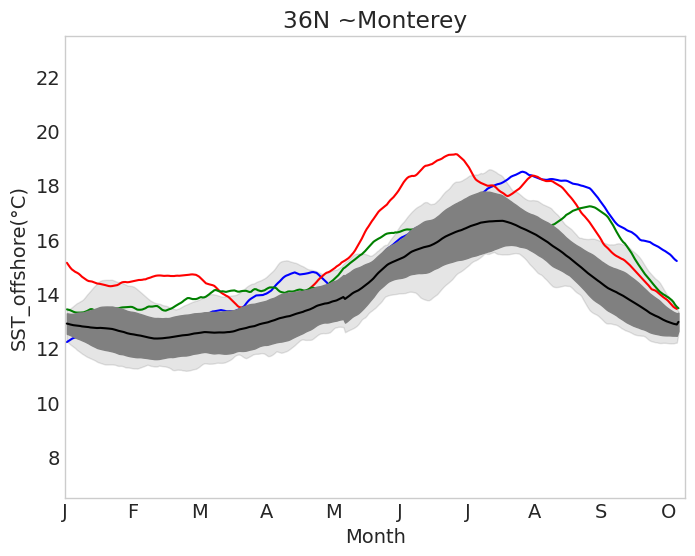

In [137]:
# plot rolling means for 2002-2013
rollings_grouped.plot(x='day_of_year', color='black', zorder=4)

# plot 2014, 2015, 2016
ds14.plot(x='day_of_year', color='blue')
ds15.plot(x='day_of_year', color='red')
ds16.plot(x='day_of_year', color='green')

# create shaded area for maximum/minimum, opaque area for +- 1 SD 
plt.fill_between(rollings_sds.day_of_year, rollings_sds.sd_lower_bound, rollings_sds.sd_upper_bound, zorder=3, color='gray')
plt.fill_between(extremum.day_of_year, extremum.mins, extremum.maxes, alpha=0.1, color='black')

# titling and labeling, legend, gridlines
plt.title('36N ~Monterey')
plt.grid(False)
plt.xticks(np.arange(0, 480, 40), 
           ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])  
plt.xlabel('Month')
plt.ylim(6.5, 23.5)
plt.xlim(0, 370)
plt.ylabel('SST_offshore(°C)')
plt.legend(loc='upper left', labelcolor='linecolor', handlelength=0)

# plt.savefig('outputs/q06.png')